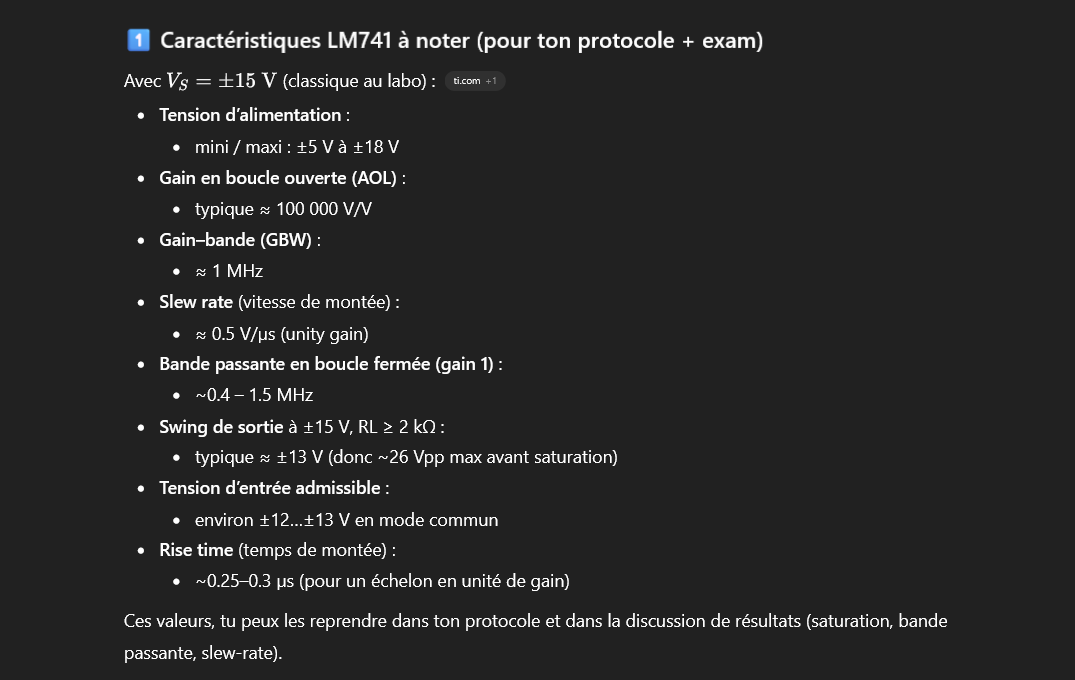

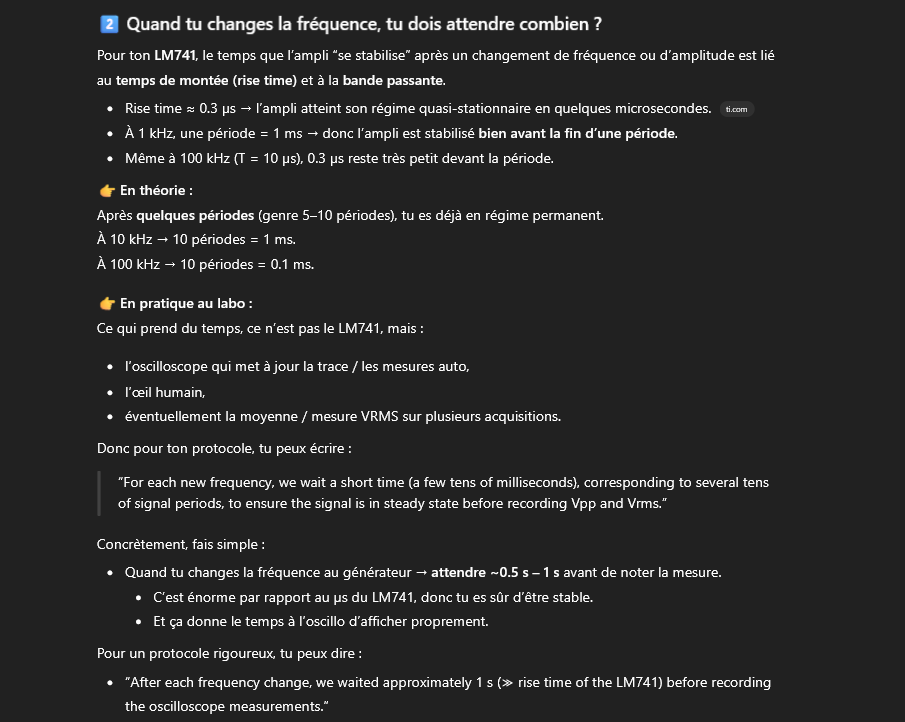

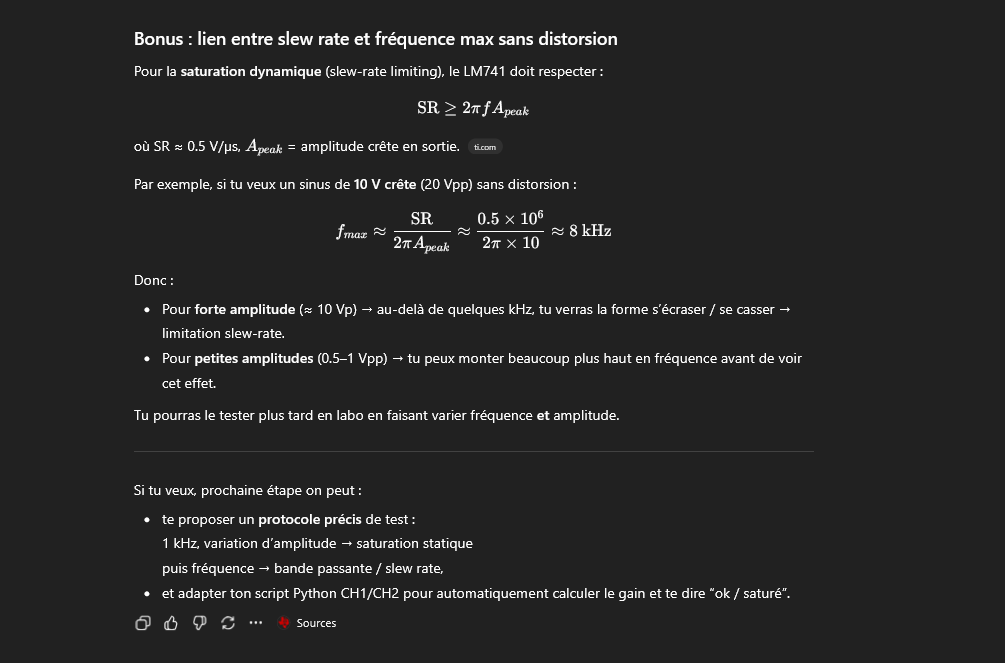

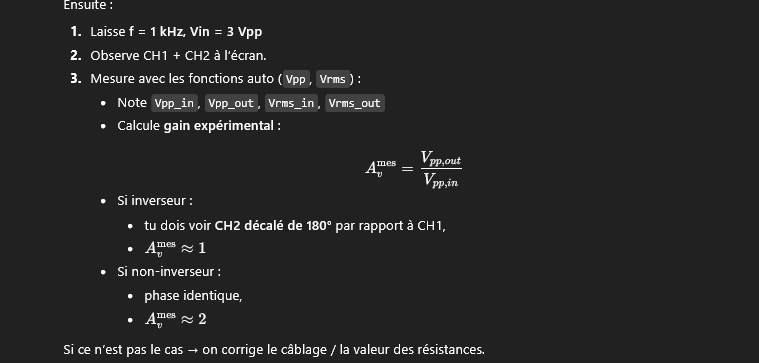

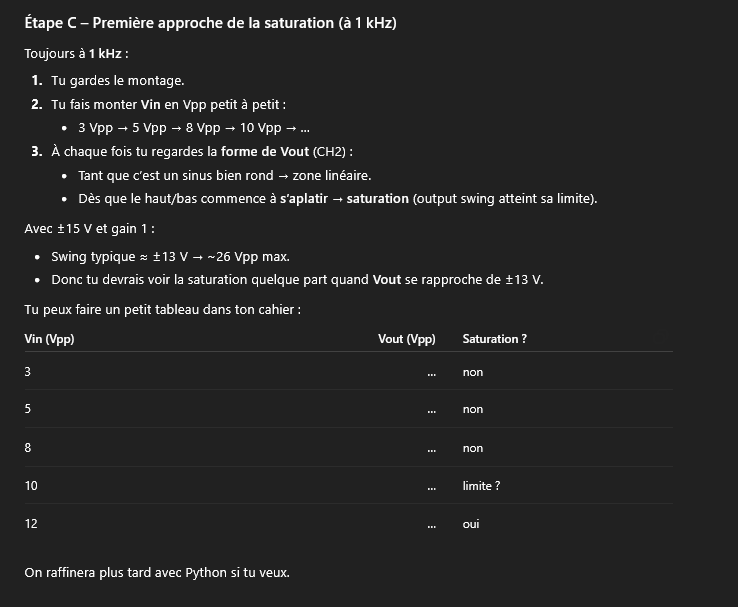

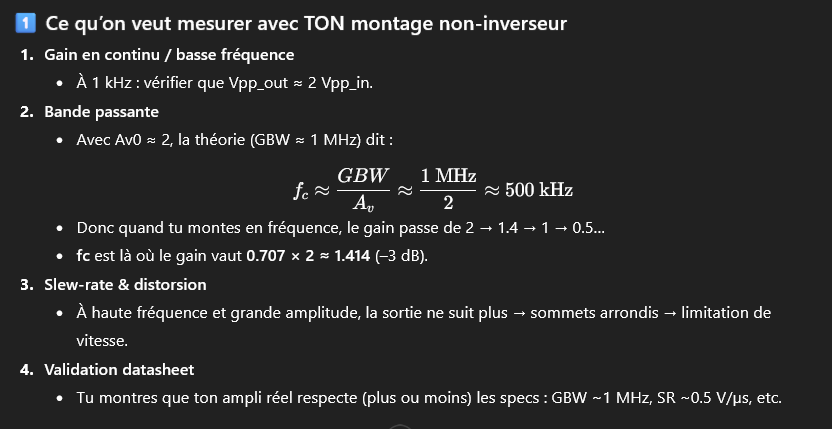

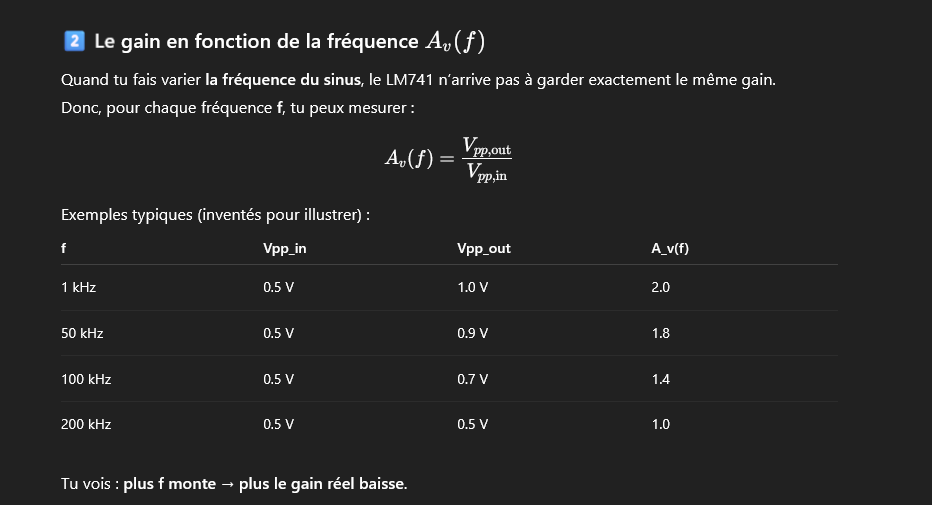

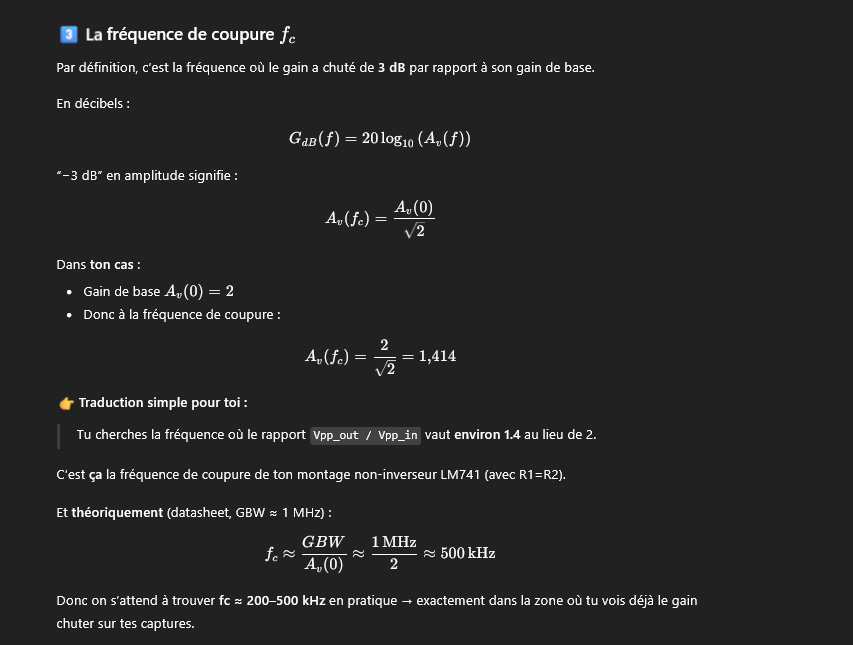

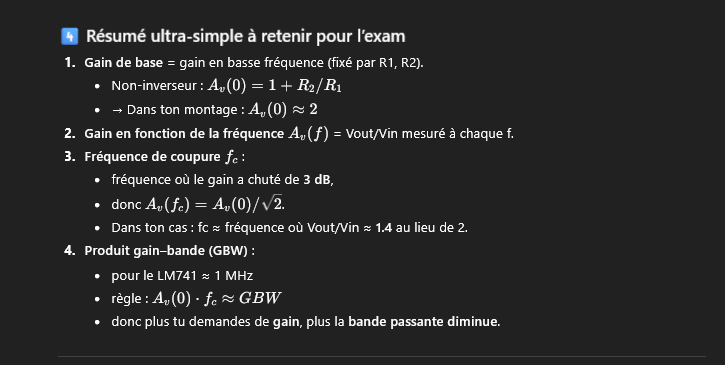

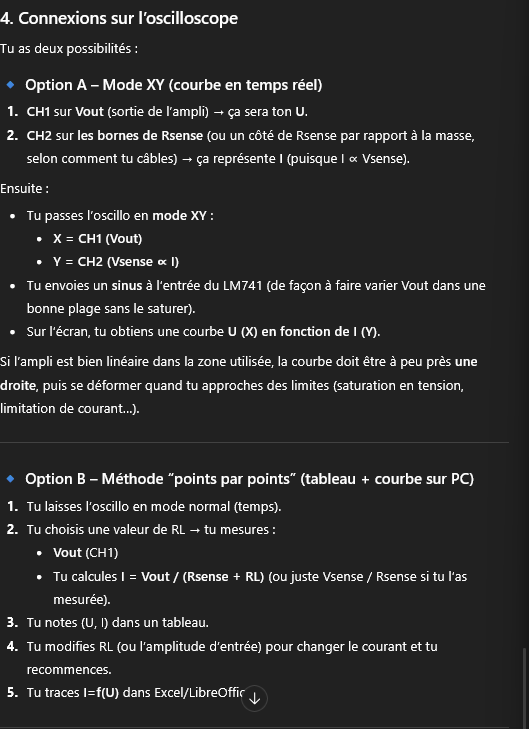

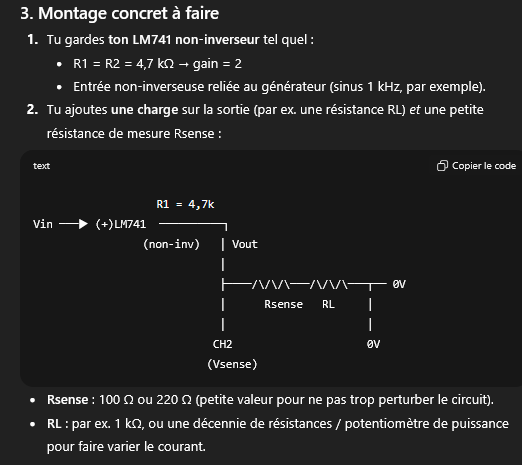

# Gain, frequence de coupure et gain bande passante

In [6]:
import pyvisa

rm = pyvisa.ResourceManager()
print("Ressources trouvées :", rm.list_resources())

scope = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR")
print("Scope ID :", scope.query("*IDN?"))
scope.close()


Ressources trouvées : ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Scope ID : RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4



In [13]:
import pyvisa

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
print("Ressources trouvées :", resources)

generator_addr = None
scope_addr = None

for addr in resources:
    # On classe juste avec le texte de l'adresse
    if "DG1D" in addr or "DG" in addr:
        generator_addr = addr
    elif "DS1Z" in addr or "DS" in addr:
        scope_addr = addr

print("Générateur :", generator_addr)
print("Oscilloscope :", scope_addr)

# Maintenant on ouvre vraiment les deux
generator = rm.open_resource(generator_addr)
scope = rm.open_resource(scope_addr)

generator.timeout = 3000
generator.read_termination = '\n'
generator.write_termination = '\n'

scope.timeout = 3000
scope.read_termination = '\n'
scope.write_termination = '\n'

Ressources trouvées : ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Générateur : USB0::0x0400::0x09C4::DG1F143800623::INSTR
Oscilloscope : USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR


In [17]:
import pyvisa

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
print("Ressources trouvées :", resources)

generator_addr = None
scope_addr = None

for addr in resources:
    if "DG" in addr:        # générateur Rigol DG...
        generator_addr = addr
    elif "DS" in addr:      # oscillo Rigol DS...
        scope_addr = addr

print("Générateur :", generator_addr)
print("Oscilloscope :", scope_addr)

if generator_addr is None or scope_addr is None:
    raise RuntimeError("Impossible de trouver générateur ou oscilloscope !")

# --- Ouverture des instruments ---
generator = rm.open_resource(generator_addr)
scope = rm.open_resource(scope_addr)

for inst in (generator, scope):
    inst.timeout = 5000
    inst.read_termination = '\n'
    inst.write_termination = '\n'

# --- On NE FAIT PAS de query sur le générateur ---
# On configure juste le signal pour le LM741

# Sinus 1 kHz, 1 Vpp, offset 0 V sur CH1
generator.write(":SOUR1:APPL:SIN 10000,3,0")
generator.write(":OUTP1 ON")
print("Signal 1 kHz, 1 Vpp envoyé sur CH1 du générateur.")

# Pour vérif côté oscillo, là on peut faire un *IDN?
#print("Scope ID :", scope.query("*IDN?"))

# Tu continues ensuite avec la partie acquisition du scope...
# (lecture de CH1 = entrée LM741, CH2 = sortie LM741)
scope.close()   

Ressources trouvées : ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Générateur : USB0::0x0400::0x09C4::DG1F143800623::INSTR
Oscilloscope : USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR
Signal 1 kHz, 1 Vpp envoyé sur CH1 du générateur.


# recup oscillo

In [33]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

# ========= Fonctions utilitaires =========

def read_waveform(scope, channel: str):
    """
    Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v) en secondes / volts.
    """
    # On met le format/ mode ici, au cas où
    try:
        scope.write(":WAV:FORM ASCII")
        scope.write(":WAV:MODE NORM")
    except Exception:
        pass

    scope.write(f":WAV:SOUR {channel}")
    pre = scope.query(":WAV:PRE?").strip().split(",")

    xinc  = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yinc  = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    raw = scope.query(":WAV:DATA?")

    # En-tête #9xxxxx éventuelle
    if raw.startswith("#"):
        nd = int(raw[1])
        nb = int(raw[2:2+nd])
        raw = raw[2+nd : 2+nd+nb]

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig

    return t, v

def compute_characteristics(t, v):
    Vmin = float(v.min())
    Vmax = float(v.max())
    Vpp  = Vmax - Vmin
    Vrms = float(np.sqrt(np.mean(v**2)))

    i1 = np.argmax(v)
    if i1 + 1 < len(v) - 1:
        i2_rel = np.argmax(v[i1+1:])
        i2 = i1 + 1 + i2_rel
        T_est = t[i2] - t[i1]
        f_est = 1.0 / T_est if T_est > 0 else float("nan")
    else:
        T_est = float("nan")
        f_est = float("nan")

    return {
        "Vmin": Vmin,
        "Vmax": Vmax,
        "Vpp": Vpp,
        "Vrms": Vrms,
        "T": T_est,
        "f": f_est,
    }

def detect_saturation(v, threshold_ratio=0.95):
    Vmin = v.min()
    Vmax = v.max()
    amp = (Vmax - Vmin) / 2
    if amp == 0:
        return False

    upper_level = Vmin + threshold_ratio * (Vmax - Vmin)
    lower_level = Vmin + (1 - threshold_ratio) * (Vmax - Vmin)

    frac_high = np.mean(v >= upper_level)
    frac_low  = np.mean(v <= lower_level)

    return (frac_high > 0.1) or (frac_low > 0.1)

# ========= Programme principal =========

rm = pyvisa.ResourceManager()
scope = rm.open_resource(SCOPE_ID)
scope.timeout = 5000
# scope.encoding = "ascii"  # souvent inutile, tu peux le laisser ou le commenter

# Tentative de *IDN?* mais on NE plante pas si ça foire
try:
    print("SCOPE:", scope.query("*IDN?").strip())
except Exception as e:
    print("Impossible de lire *IDN?*, on continue :", e)

# Tentative de STOP mais là aussi, si ça râle on s'en fout
try:
    scope.write(":STOP")
except Exception as e:
    print("Impossible de STOP, on continue :", e)

# ----- Lire CH1 et CH2 -----
t1, v1 = read_waveform(scope, "CHAN1")   # CH1 = entrée
t2, v2 = read_waveform(scope, "CHAN2")   # CH2 = sortie

t = t1

car1 = compute_characteristics(t1, v1)
car2 = compute_characteristics(t2, v2)

print("\n=== CH1 (entrée) ===")
for k, val in car1.items():
    print(f"{k} = {val}")

print("\n=== CH2 (sortie) ===")
for k, val in car2.items():
    print(f"{k} = {val}")

if car1["Vpp"] > 0:
    gain_lin = car2["Vpp"] / car1["Vpp"]
    gain_db  = 20 * np.log10(abs(gain_lin))
else:
    gain_lin = float("nan")
    gain_db = float("nan")

print(f"\nGain (Vpp_out / Vpp_in) = {gain_lin:.3f}  ({gain_db:.2f} dB)")

sat1 = detect_saturation(v1)
sat2 = detect_saturation(v2)
print(f"Saturation CH1 ? {sat1}")
print(f"Saturation CH2 ? {sat2}")

plt.figure(figsize=(10,5))
plt.plot(t*1e3, v1, label="CH1 (entrée)")
plt.plot(t*1e3, v2, label="CH2 (sortie)")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("Deux canaux mesurés (préparation LM741)")
plt.grid()
plt.legend()
plt.show()

# Remettre en RUN si possible
try:
    scope.write(":RUN")
except Exception:
    pass

scope.close()
rm.close()


Impossible de lire *IDN?*, on continue : VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).
Impossible de STOP, on continue : VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).


VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

In [32]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0. CONFIG INSTRUMENTS
# =========================

# ID de l'oscilloscope (le tien)
SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

# ID du générateur (à adapter si tu veux le piloter aussi)
GEN_ID = "USB0::0x0400::0x09C4::DG1F143800623::INSTR"

# Résistance de mesure du courant de sortie (en ohms)
# => mise en série avec la sortie du LM741 vers la masse
Rsense = 100.0  # par ex. 100 Ω


# =========================
# 1. FONCTIONS UTILITAIRES
# =========================

def read_waveform(scope, channel: str):
    """
    Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v)
    t en secondes, v en volts.

    scope  : handler pyvisa de l'oscilloscope
    channel: "CHAN1" ou "CHAN2"
    """

    # On choisit la source de la waveform
    scope.write(f":WAV:SOUR {channel}")
    # On récupère les paramètres de préambule
    pre = scope.query(":WAV:PRE?").strip().split(",")

    # Décodage du préambule (Rigol DS1000Z)
    xinc  = float(pre[4])  # incrément en temps par point
    xorig = float(pre[5])  # origine en temps
    xref  = float(pre[6])  # référence en temps (index)
    yinc  = float(pre[7])  # incrément en tension par "unit"
    yorig = float(pre[8])  # origine en tension
    yref  = float(pre[9])  # référence en tension (offset)

    # Lecture des données brutes
    raw = scope.query(":WAV:DATA?")

    # En-tête SCPI de type "#9xxxxx" à enlever
    if raw.startswith("#"):
        nd = int(raw[1])              # nb de digits pour la taille
        nb = int(raw[2:2+nd])         # taille effective
        raw = raw[2+nd : 2+nd+nb]     # on ne garde que les données

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    # Reconstruction temporelle et en volts
    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig

    return t, v


def compute_characteristics(t, v):
    """
    Renvoie un dictionnaire avec les caractéristiques de base:
    - Vmin, Vmax, Vpp, Vrms
    - période T estimée, fréquence f estimée

    t : vecteur temps (s)
    v : vecteur tension (V)
    """
    Vmin = float(v.min())
    Vmax = float(v.max())
    Vpp  = Vmax - Vmin
    Vrms = float(np.sqrt(np.mean(v**2)))

    # Estimation rapide de la période avec la distance entre 2 maxima
    i1 = np.argmax(v)
    if i1 + 1 < len(v) - 1:
        i2_rel = np.argmax(v[i1+1:])
        i2 = i1 + 1 + i2_rel
        T_est = t[i2] - t[i1]
        f_est = 1.0 / T_est if T_est > 0 else float("nan")
    else:
        T_est = float("nan")
        f_est = float("nan")

    return {
        "Vmin": Vmin,
        "Vmax": Vmax,
        "Vpp": Vpp,
        "Vrms": Vrms,
        "T": T_est,
        "f": f_est,
    }


def detect_saturation(v, threshold_ratio=0.95):
    """
    Détection simple de saturation/clipping d'un signal.

    Idee : si une grosse fraction des points est très proche de Vmax ou Vmin,
    on considère que le signal est "écrêté".

    threshold_ratio : ex. 0.95 => on regarde au-dessus de 95% de Vpp
    """
    Vmin = v.min()
    Vmax = v.max()
    amp = (Vmax - Vmin) / 2
    if amp == 0:
        return False

    upper_level = Vmin + threshold_ratio * (Vmax - Vmin)
    lower_level = Vmin + (1 - threshold_ratio) * (Vmax - Vmin)

    frac_high = np.mean(v >= upper_level)
    frac_low  = np.mean(v <= lower_level)

    # si >10% des points sont collés en haut ou en bas -> clipping probable
    return (frac_high > 0.1) or (frac_low > 0.1)


def compute_IV_curve(v_out, Rsense):
    """
    À partir de la tension de sortie v_out(t) et de la résistance Rsense,
    calcule le courant de sortie I(t) et renvoie (U, I).

    U = v_out (tension de sortie)
    I = v_out / Rsense (approx, si Rsense = seule charge)

    On peut ensuite tracer I=f(U) avec matplotlib.
    """
    I = v_out / Rsense  # en ampères
    U = v_out           # en volts
    return U, I


# =========================
# 2. FONCTIONS AVANCÉES :
#    BALAYAGE EN FRÉQUENCE
# =========================

def configure_generator(gen, freq_hz, vpp=1.0):
    """
    Configure le générateur:
    - Sinus
    - fréquence freq_hz
    - amplitude vpp (Vpp)
    - sortie ON

    À adapter selon la doc exacte de ton générateur.
    """
    gen.write(":SOUR1:FUNC SIN")
    gen.write(f":SOUR1:FREQ {freq_hz}")
    gen.write(f":SOUR1:VOLT {vpp}")
    gen.write(":OUTP1 ON")


def measure_gain(scope):
    """
    Mesure Vpp sur CH1 (entrée) et CH2 (sortie),
    renvoie (gain_lin, gain_db, car1, car2, t1, v1, t2, v2)
    pour pouvoir exploiter ensuite.
    """
    # On suppose même base de temps pour CH1 et CH2
    t1, v1 = read_waveform(scope, "CHAN1")  # entrée LM741
    t2, v2 = read_waveform(scope, "CHAN2")  # sortie LM741

    car1 = compute_characteristics(t1, v1)
    car2 = compute_characteristics(t2, v2)

    if car1["Vpp"] > 0:
        gain_lin = car2["Vpp"] / car1["Vpp"]
        gain_db  = 20 * np.log10(abs(gain_lin))
    else:
        gain_lin = float("nan")
        gain_db  = float("nan")

    return gain_lin, gain_db, car1, car2, t1, v1, t2, v2


def sweep_bandwidth(scope, gen, freqs_hz, vpp=1.0):
    """
    Balaye une liste de fréquences freqs_hz,
    mesure le gain (Vpp_out / Vpp_in) pour chaque,
    renvoie (freqs, gains_db).
    """
    gains_db = []

    for f in freqs_hz:
        configure_generator(gen, f, vpp=vpp)
        # Laisser le temps au circuit de se stabiliser
        scope.write(":STOP")
        scope.write(":RUN")
        scope.write(":STOP")  # on fige la forme à cette fréquence

        gain_lin, gain_db, *_ = measure_gain(scope)
        gains_db.append(gain_db)
        print(f"f = {f:.1f} Hz -> gain = {gain_db:.2f} dB")

    return np.array(freqs_hz), np.array(gains_db)


# =========================
# 3. PROGRAMME PRINCIPAL
# =========================

def main():
    rm = pyvisa.ResourceManager()

    # --- Connexion instruments ---
    scope = rm.open_resource(SCOPE_ID)
    scope.timeout = 5000
    scope.encoding = "ascii"
    print("SCOPE:", scope.query("*IDN?").strip())

    # (Optionnel) générateur :
    try:
        gen = rm.open_resource(GEN_ID)
        gen.timeout = 5000
        gen.encoding = "ascii"
        print("GEN  :", gen.query("*IDN?").strip())
    except Exception as e:
        gen = None
        print("Pas de générateur trouvé / utilisé :", e)

    # --- Réglage de l'oscillo pour l'acquisition ---
    scope.write(":STOP")        # on fige l'écran pour une mesure stable
    scope.write(":WAV:FORM ASCII")
    scope.write(":WAV:MODE NORM")

    # =========================
    # 3.1. MESURE SIMPLE U/I
    # =========================

    # Si tu as un générateur piloté :
    if gen is not None:
        # Exemple : sinus 1 kHz, 1 Vpp
        configure_generator(gen, freq_hz=1000.0, vpp=1.0)

    # On lit CH1 (entrée) et CH2 (sortie)
    t1, v1 = read_waveform(scope, "CHAN1")  # entrée Vin
    t2, v2 = read_waveform(scope, "CHAN2")  # sortie Vout

    car1 = compute_characteristics(t1, v1)
    car2 = compute_characteristics(t2, v2)

    print("\n=== CH1 (entrée LM741) ===")
    for k, val in car1.items():
        print(f"{k} = {val}")

    print("\n=== CH2 (sortie LM741) ===")
    for k, val in car2.items():
        print(f"{k} = {val}")

    if car1["Vpp"] > 0:
        gain_lin = car2["Vpp"] / car1["Vpp"]
        gain_db  = 20 * np.log10(abs(gain_lin))
    else:
        gain_lin = float("nan")
        gain_db  = float("nan")

    print(f"\nGain (Vpp_out / Vpp_in) = {gain_lin:.3f}  ({gain_db:.2f} dB)")

    # Détection de saturation aux 2 bornes
    sat1 = detect_saturation(v1)
    sat2 = detect_saturation(v2)
    print(f"Saturation CH1 ? {sat1}")
    print(f"Saturation CH2 ? {sat2}")

    # ----- Tracé temporel -----
    plt.figure(figsize=(10, 4))
    plt.plot(t1 * 1e3, v1, label="CH1 (entrée Vin)")
    plt.plot(t2 * 1e3, v2, label="CH2 (sortie Vout)")
    plt.xlabel("Temps (ms)")
    plt.ylabel("Tension (V)")
    plt.title("LM741 - entrée / sortie")
    plt.grid()
    plt.legend()

    # =========================
    # 3.2. COURBE U/I (CARACTÉRISTIQUE)
    # =========================
    U, I = compute_IV_curve(v2, Rsense)  # U = Vout, I = Vout/Rsense

    plt.figure(figsize=(6, 6))
    plt.plot(U, I)
    plt.xlabel("Tension de sortie U (V)")
    plt.ylabel("Courant de sortie I (A)")
    plt.title("Caractéristique U / I du montage LM741")
    plt.grid()

    # =========================
    # 3.3. BALAYAGE BANDE PASSANTE (OPTION)
    # =========================
    if gen is not None:
        # Exemple : balayage log entre 10 Hz et 100 kHz
        freqs = np.logspace(1, 5, 15)  # 10^1=10 Hz ... 10^5=100 kHz
        freqs, gains_db = sweep_bandwidth(scope, gen, freqs, vpp=0.5)

        # Gain bas fréquence pris comme référence pour -3 dB
        G0 = gains_db[0]
        target = G0 - 3.0

        # Recherche approximative de la fréquence de coupure
        f_cut = np.nan
        for f, g in zip(freqs, gains_db):
            if g <= target:
                f_cut = f
                break

        print(f"\nFréquence de coupure approximative (−3 dB) ≈ {f_cut} Hz")

        # Tracé Bode (gain)
        plt.figure(figsize=(8, 4))
        plt.semilogx(freqs, gains_db, marker="o")
        plt.axhline(G0, linestyle="--", label="Gain basse fréquence")
        plt.axhline(target, linestyle="--", label="Gain -3 dB")
        plt.xlabel("Fréquence (Hz)")
        plt.ylabel("Gain (dB)")
        plt.title("Bande passante du LM741 (mesure Vpp)")
        plt.grid(True, which="both")
        plt.legend()

    # Affiche toutes les figures
    plt.show()

    # --- Remettre en RUN ---
    scope.write(":RUN")
    scope.close()
    if gen is not None:
        gen.write(":OUTP1 OFF")
        gen.close()
    rm.close()


if __name__ == "__main__":
    main()


VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

In [35]:
import pyvisa

rm = pyvisa.ResourceManager()
print("Ressources trouvées :", rm.list_resources())

for res in rm.list_resources():
    try:
        inst = rm.open_resource(res)
        inst.timeout = 3000
        inst.write_termination = "\n"
        inst.read_termination = "\n"
        idn = inst.query("*IDN?")
        print(res, "->", idn.strip())
        inst.close()
    except Exception as e:
        print(res, "-> ERREUR:", e)

rm.close()


Ressources trouvées : ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR -> ERREUR: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).
USB0::0x0400::0x09C4::DG1F143800623::INSTR -> RIGOL TECHNOLOGIES,DG1022A,DG1F143800623,,00.03.00.08.00.01.02
ASRL7::INSTR -> ERREUR: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).
ASRL8::INSTR -> ERREUR: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.



=== CH1 (entrée) ===
Vmin = -26.519995
Vmax = -24.279995200000002
Vpp = 2.2399997999999997
Vrms = 25.440552534095183
T = 2.0000000000000486e-06
f = 499999.99999998783

=== CH2 (sortie) ===
Vmin = -25.559995060000002
Vmax = -25.31999506
Vpp = 0.240000000000002
Vrms = 25.448191249879738
T = 5.200000000000018e-05
f = 19230.769230769165

Gain (Vpp_out / Vpp_in) = 0.107  (-19.40 dB)
Saturation CH1 ? False
Saturation CH2 ? False


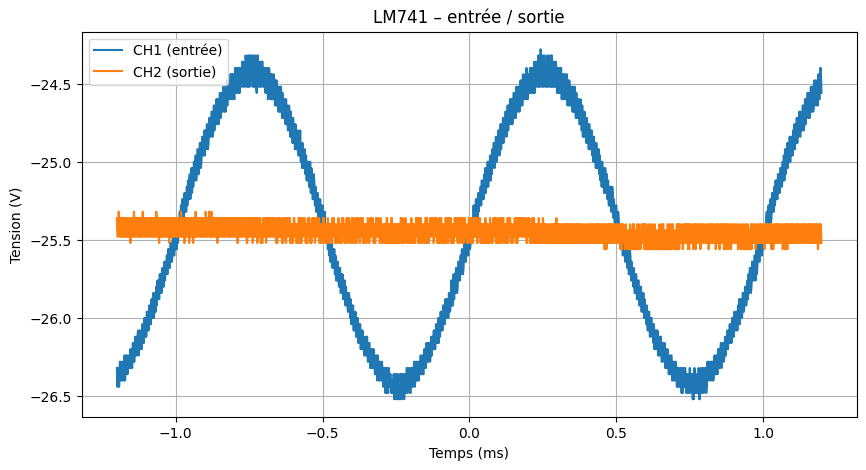

In [37]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

rm = pyvisa.ResourceManager()

# ====== OUVERTURE OSCILLO COMME LE GENERATOR DANS LAB1 ======
scope = rm.open_resource(SCOPE_ID)

scope.timeout = 10000              # comme pour ton générateur
scope.read_termination = '\n'
scope.write_termination = '\n'
scope.chunk_size = 102400
scope.clear()                      # très important pour virer les merdes de buffer

# *** ON ENLÈVE CE QUI POSE PROBLÈME ***
# PAS de *IDN?*
# PAS de :STOP
# PAS de :WAV:FORM
# PAS de :WAV:MODE
# -> on laisse l’oscillo tel qu’il est, comme quand tu le contrôles à la main

# ----- Lire CH1 et CH2 -----
t1, v1 = read_waveform(scope, "CHAN1")   # CH1 = entrée LM741
t2, v2 = read_waveform(scope, "CHAN2")   # CH2 = sortie LM741

t = t1  # même base de temps

# ----- Caractéristiques -----
car1 = compute_characteristics(t1, v1)
car2 = compute_characteristics(t2, v2)

print("\n=== CH1 (entrée) ===")
for k, val in car1.items():
    print(f"{k} = {val}")

print("\n=== CH2 (sortie) ===")
for k, val in car2.items():
    print(f"{k} = {val}")

# Gain LM741
if car1["Vpp"] > 0:
    gain_lin = car2["Vpp"] / car1["Vpp"]
    gain_db  = 20 * np.log10(abs(gain_lin))
else:
    gain_lin = float("nan")
    gain_db = float("nan")

print(f"\nGain (Vpp_out / Vpp_in) = {gain_lin:.3f}  ({gain_db:.2f} dB)")

# Détection saturation
sat1 = detect_saturation(v1)
sat2 = detect_saturation(v2)
print(f"Saturation CH1 ? {sat1}")
print(f"Saturation CH2 ? {sat2}")

# ----- Tracé -----
plt.figure(figsize=(10,5))
plt.plot(t*1e3, v1, label="CH1 (entrée)")
plt.plot(t*1e3, v2, label="CH2 (sortie)")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("LM741 – entrée / sortie")
plt.grid()
plt.legend()
plt.show()

scope.close()
rm.close()


Ressources trouvées : ('USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Générateur : USB0::0x0400::0x09C4::DG1F143800623::INSTR
Oscilloscope : USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR

=== Mesure simple LM741 ===
Fréquence : 1 Hz
Vin_pp  = 0.001 V
Vout_pp = 0.000 V
Gain    = 0.040  (-27.96 dB)
Saturation entrée ? True
Saturation sortie ? True


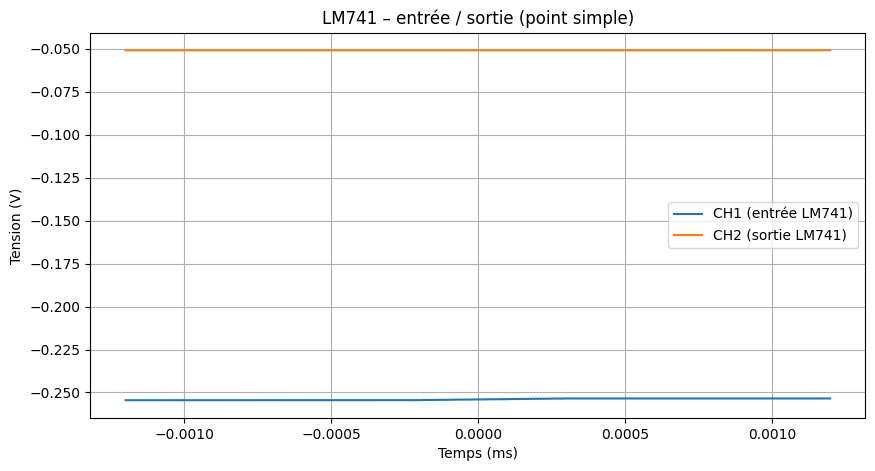

f =    100.0 Hz -> gain = 0.040 (-27.96 dB)
f =    200.0 Hz -> gain = 0.040 (-27.96 dB)
f =    500.0 Hz -> gain = 0.040 (-27.96 dB)
f =   1000.0 Hz -> gain = 0.040 (-27.96 dB)
f =   2000.0 Hz -> gain = 0.040 (-27.96 dB)
f =   5000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  10000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  20000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  50000.0 Hz -> gain = 0.040 (-27.96 dB)
f = 100000.0 Hz -> gain = 0.040 (-27.96 dB)


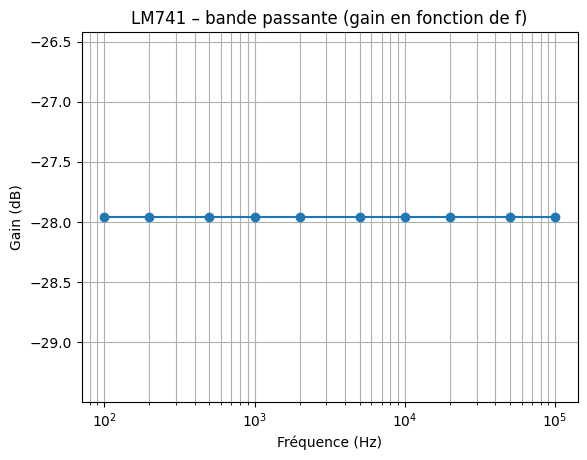


Gain max ≈ -27.96 dB, fréquence de coupure fc ≈ nan Hz
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True


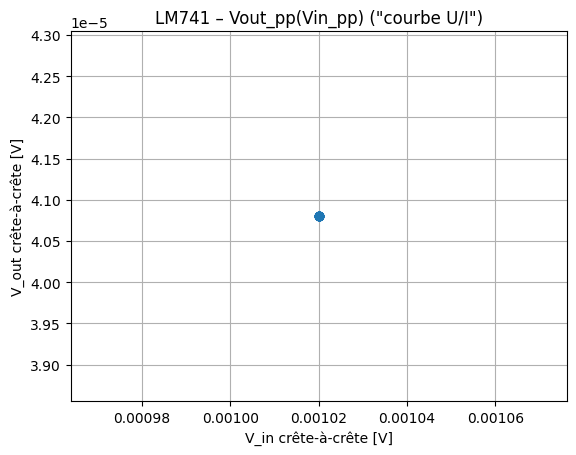

Saturation de sortie détectée à partir de Vin_pp ≈ 0.001020000600000015 V


In [1]:
import time
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0. Détection des instruments
# =========================

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
print("Ressources trouvées :", resources)

GEN_ADDR = None
SCOPE_ADDR = None

for addr in resources:
    if "DG" in addr:         # générateur Rigol DG...
        GEN_ADDR = addr
    elif "DS" in addr:       # oscillo Rigol DS...
        SCOPE_ADDR = addr

print("Générateur :", GEN_ADDR)
print("Oscilloscope :", SCOPE_ADDR)

if GEN_ADDR is None or SCOPE_ADDR is None:
    raise RuntimeError("Impossible de trouver générateur ou oscilloscope !")


# =========================
# 1. Fonctions UTILITAIRES OSCILLO
# =========================

def read_waveform(scope, channel: str):
    """
    Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v) en secondes / volts.
    Utilise les commandes :WAV:SOUR / :WAV:PRE? / :WAV:DATA?
    (logique lab1 qui fonctionne chez toi).
    """
    scope.write(f":WAV:SOUR {channel}")
    pre = scope.query(":WAV:PRE?").strip().split(",")

    xinc  = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yinc  = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    raw = scope.query(":WAV:DATA?")

    # Gestion éventuelle d'un header binaire #9xxxxx
    if raw.startswith("#"):
        nd = int(raw[1])
        nb = int(raw[2:2+nd])
        raw = raw[2+nd : 2+nd+nb]

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig

    return t, v


def compute_characteristics(t, v):
    """
    Renvoie un dict avec Vmin, Vmax, Vpp, Vrms, fréquence estimée.
    """
    Vmin = float(v.min())
    Vmax = float(v.max())
    Vpp  = Vmax - Vmin
    Vrms = float(np.sqrt(np.mean(v**2)))

    # Estimation grossière de la période : distance entre 2 maxima
    i1 = np.argmax(v)
    if i1 + 1 < len(v) - 1:
        i2_rel = np.argmax(v[i1+1:])
        i2 = i1 + 1 + i2_rel
        T_est = t[i2] - t[i1]
        f_est = 1.0 / T_est if T_est > 0 else float("nan")
    else:
        T_est = float("nan")
        f_est = float("nan")

    return {
        "Vmin": Vmin,
        "Vmax": Vmax,
        "Vpp": Vpp,
        "Vrms": Vrms,
        "T": T_est,
        "f": f_est,
    }


def detect_saturation(v, threshold_ratio=0.95):
    """
    Détection très simple de saturation/clipping :
    si beaucoup d'échantillons sont proches de Vmax ou Vmin.
    """
    Vmin = v.min()
    Vmax = v.max()
    amp = (Vmax - Vmin) / 2
    if amp == 0:
        return False

    upper_level = Vmin + threshold_ratio * (Vmax - Vmin)
    lower_level = Vmin + (1 - threshold_ratio) * (Vmax - Vmin)

    frac_high = np.mean(v >= upper_level)
    frac_low  = np.mean(v <= lower_level)

    return (frac_high > 0.1) or (frac_low > 0.1)


# =========================
# 2. Fonctions UTILITAIRES GENERATEUR
# =========================

def config_generator(gen, channel=1, wave="SIN", freq=1e3, vpp=1.0, offset=0.0):
    """
    Configure le générateur Rigol :
      - channel : 1 ou 2
      - wave    : "SIN", "SQU", ...
      - freq    : fréquence en Hz
      - vpp     : amplitude crête-à-crête en Volts
      - offset  : offset DC en Volts
    """
    # Commande type :SOUR1:APPL:SIN 1000,1.0,0
    gen.write(f":SOUR{channel}:APPL:{wave} {freq},{vpp},{offset}")
    gen.write(f":OUTP{channel} ON")


def stop_generator(gen, channel=1):
    """
    Coupe la sortie du canal choisi.
    """
    gen.write(f":OUTP{channel} OFF")


# =========================
# 3. Mesure UNIQUE : gain + saturation LM741
# =========================

def measure_lm741_point(gen, scope, freq=1e3, vpp_in=1.0, offset=0.0, channel_gen=1):
    """
    - Configure le générateur (freq, vpp_in, offset) sur channel_gen
    - Lit CH1 (entrée LM741) et CH2 (sortie LM741)
    - Retourne un dict avec gain, saturation, etc.
    """
    # 1) Config générateur
    config_generator(gen, channel=channel_gen, wave="SIN", freq=freq, vpp=vpp_in, offset=offset)
    time.sleep(0.1)  # laisse le temps au système de se stabiliser

    # 2) Lecture oscillo
    t1, v1 = read_waveform(scope, "CHAN1")   # CH1 = entrée LM741
    t2, v2 = read_waveform(scope, "CHAN2")   # CH2 = sortie LM741

    car1 = compute_characteristics(t1, v1)
    car2 = compute_characteristics(t2, v2)

    if car1["Vpp"] > 0:
        gain_lin = car2["Vpp"] / car1["Vpp"]
        gain_db  = 20 * np.log10(abs(gain_lin))
    else:
        gain_lin = float("nan")
        gain_db  = float("nan")

    sat1 = detect_saturation(v1)
    sat2 = detect_saturation(v2)

    result = {
        "freq": freq,
        "Vin_pp": car1["Vpp"],
        "Vout_pp": car2["Vpp"],
        "gain_lin": gain_lin,
        "gain_db": gain_db,
        "sat_in": sat1,
        "sat_out": sat2,
        "t": t1,
        "vin": v1,
        "vout": v2,
    }
    return result


# =========================
# 4. Sweeps : bande passante & "courbe U/I"
# =========================

def sweep_frequency(gen, scope, freq_list, vpp_in=1.0, offset=0.0):
    """
    Balaye une liste de fréquences pour tracer la bande passante du LM741.
    Retourne (freq_array, gain_db_array).
    """
    gains_db = []
    for f in freq_list:
        res = measure_lm741_point(gen, scope, freq=f, vpp_in=vpp_in, offset=offset)
        gains_db.append(res["gain_db"])
        print(f"f = {f:8.1f} Hz -> gain = {res['gain_lin']:.3f} ({res['gain_db']:.2f} dB)")
    return np.array(freq_list), np.array(gains_db)


def sweep_amplitude(gen, scope, vpp_list, freq=1e3, offset=0.0):
    """
    Balaye l'amplitude d'entrée pour tracer Vout_pp(Vin_pp)
    et voir la saturation (courbe "U/I").
    Retourne (Vin_pp_array, Vout_pp_array, sat_out_array).
    """
    vin_pp = []
    vout_pp = []
    sat_out = []

    for vpp in vpp_list:
        res = measure_lm741_point(gen, scope, freq=freq, vpp_in=vpp, offset=offset)
        vin_pp.append(res["Vin_pp"])
        vout_pp.append(res["Vout_pp"])
        sat_out.append(res["sat_out"])
        print(f"Vin_pp = {res['Vin_pp']:.3f} V -> Vout_pp = {res['Vout_pp']:.3f} V  "
              f"gain = {res['gain_lin']:.2f}, sat_out = {res['sat_out']}")

    return np.array(vin_pp), np.array(vout_pp), np.array(sat_out)


# =========================
# 5. PROGRAMME PRINCIPAL : exemples
# =========================

# --- Ouverture des instruments (style lab1) ---
gen = rm.open_resource(GEN_ADDR)
gen.timeout = 10000
gen.read_termination = '\n'
gen.write_termination = '\n'
gen.chunk_size = 102400
gen.clear()

scope = rm.open_resource(SCOPE_ADDR)
scope.timeout = 10000
scope.read_termination = '\n'
scope.write_termination = '\n'
scope.chunk_size = 102400
scope.clear()

# ========== EXEMPLE 1 : mesure simple LM741 (gain, saturation, tracé) ==========

res = measure_lm741_point(gen, scope, freq=1, vpp_in=1.0, offset=0.0, channel_gen=1)

print("\n=== Mesure simple LM741 ===")
print(f"Fréquence : {res['freq']} Hz")
print(f"Vin_pp  = {res['Vin_pp']:.3f} V")
print(f"Vout_pp = {res['Vout_pp']:.3f} V")
print(f"Gain    = {res['gain_lin']:.3f}  ({res['gain_db']:.2f} dB)")
print(f"Saturation entrée ? {res['sat_in']}")
print(f"Saturation sortie ? {res['sat_out']}")

plt.figure(figsize=(10,5))
plt.plot(res["t"]*1e3, res["vin"], label="CH1 (entrée LM741)")
plt.plot(res["t"]*1e3, res["vout"], label="CH2 (sortie LM741)")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("LM741 – entrée / sortie (point simple)")
plt.grid()
plt.legend()
plt.show()

# ========== EXEMPLE 2 : bande passante / fréquence de coupure ==========

# Liste de fréquences à mesurer (à adapter avec ce que veut le prof)
freqs = [100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
freqs_arr, gains_db_arr = sweep_frequency(gen, scope, freqs, vpp_in=1.0, offset=0.0)

plt.figure()
plt.semilogx(freqs_arr, gains_db_arr, marker="o")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain (dB)")
plt.title("LM741 – bande passante (gain en fonction de f)")
plt.grid(True, which="both")
plt.show()

# On peut approximer la fréquence de coupure fc (-3 dB sous le gain max)
gain_max = np.nanmax(gains_db_arr)
fc_candidates = freqs_arr[gains_db_arr <= gain_max - 3]
fc = fc_candidates[0] if fc_candidates.size > 0 else float("nan")
print(f"\nGain max ≈ {gain_max:.2f} dB, fréquence de coupure fc ≈ {fc} Hz")

# ========== EXEMPLE 3 : "courbe U/I" – Vout_pp vs Vin_pp + saturation ==========

# Amplitudes d'entrée à tester (attention à ne pas cramer le LM741)
vpp_list = np.linspace(0.2, 6.0, 12)  # de 0.2 Vpp à 6 Vpp par exemple
vin_pp_arr, vout_pp_arr, sat_out_arr = sweep_amplitude(gen, scope, vpp_list, freq=1e3, offset=0.0)

plt.figure()
plt.plot(vin_pp_arr, vout_pp_arr, "o-")
plt.xlabel("V_in crête-à-crête [V]")
plt.ylabel("V_out crête-à-crête [V]")
plt.title("LM741 – Vout_pp(Vin_pp) (\"courbe U/I\")")
plt.grid(True)
plt.show()

# Indication simple de la zone de saturation
idx_sat = np.where(sat_out_arr)[0]
if idx_sat.size > 0:
    print("Saturation de sortie détectée à partir de Vin_pp ≈",
          float(vin_pp_arr[idx_sat[0]]), "V")
else:
    print("Pas de saturation détectée dans la plage de Vin_pp testée.")

# ========== FIN ==========
stop_generator(gen, channel=1)
gen.close()
scope.close()
rm.close()


# generateur

Ressources VISA trouvées : ('USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Générateur : USB0::0x0400::0x09C4::DG1F143800623::INSTR
Oscilloscope : USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR

=== TEST RAPIDE GÉNÉRATEUR ===
CH1 : sinus 1 kHz, 1 Vpp ; CH2 : carré 2 kHz, 0.5 Vpp
Fin du test générateur.


=== Mesure simple LM741 ===
Fréquence : 1000.0 Hz
Vin_pp  = 0.001 V
Vout_pp = 0.000 V
Gain    = 0.040  (-27.96 dB)
Saturation entrée ? True
Saturation sortie ? True


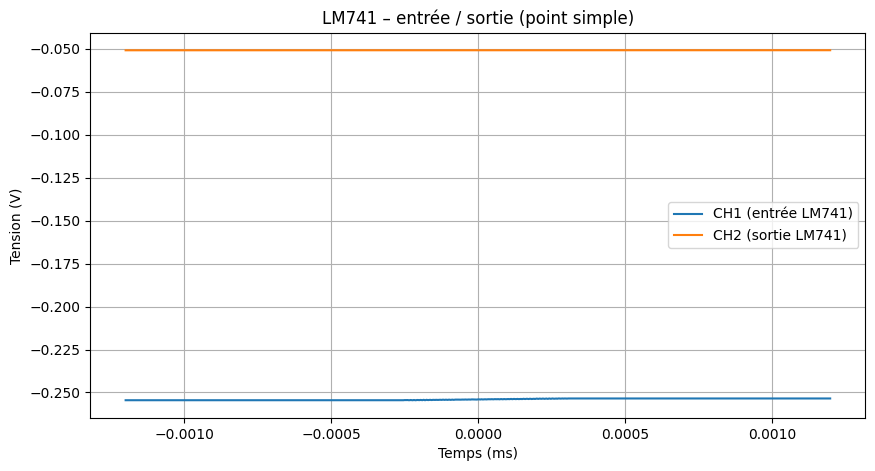

f =    100.0 Hz -> gain = 0.040 (-27.96 dB)
f =    200.0 Hz -> gain = 0.040 (-27.96 dB)
f =    500.0 Hz -> gain = 0.040 (-27.96 dB)
f =   1000.0 Hz -> gain = 0.040 (-27.96 dB)
f =   2000.0 Hz -> gain = 0.040 (-27.96 dB)
f =   5000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  10000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  20000.0 Hz -> gain = 0.040 (-27.96 dB)
f =  50000.0 Hz -> gain = 0.040 (-27.96 dB)
f = 100000.0 Hz -> gain = 0.040 (-27.96 dB)


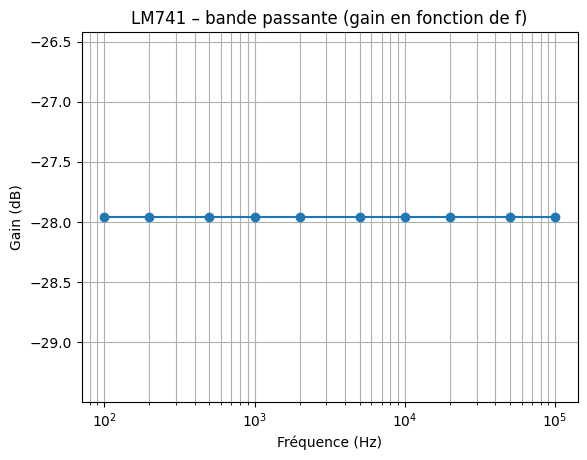

Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True
Vin_pp = 0.001 V -> Vout_pp = 0.000 V  gain = 0.04, sat_out = True


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [2]:
import time
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0. DÉTECTION DES INSTRUMENTS VISA
# ============================================================

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
print("Ressources VISA trouvées :", resources)

GEN_ADDR = None    # adresse du générateur (Rigol DG...)
SCOPE_ADDR = None  # adresse de l'oscilloscope (Rigol DS...)

for addr in resources:
    if "DG" in addr:
        GEN_ADDR = addr
    elif "DS" in addr:
        SCOPE_ADDR = addr

print("Générateur :", GEN_ADDR)
print("Oscilloscope :", SCOPE_ADDR)

if GEN_ADDR is None or SCOPE_ADDR is None:
    raise RuntimeError("Générateur ou oscilloscope non détecté !")


# ============================================================
# A. BLOC GÉNÉRATEUR – COMMANDES & TEST
# ============================================================

# --- Ouverture et configuration de base du générateur ---
gen = rm.open_resource(GEN_ADDR)
gen.timeout = 10000
gen.read_termination = '\n'
gen.write_termination = '\n'
gen.chunk_size = 102400
gen.clear()   # on vide le buffer, comme dans ton lab1


def gen_config_sinus(channel=1, freq=1e3, vpp=1.0, offset=0.0):
    """
    Configure un signal SINUS sur le générateur.

    channel : 1 ou 2
    freq    : fréquence en Hz
    vpp     : amplitude crête-à-crête (Vpp)
    offset  : offset DC (V)
    """
    gen.write(f":SOUR{channel}:APPL:SIN {freq},{vpp},{offset}")
    gen.write(f":OUTP{channel} ON")


def gen_config_carre(channel=1, freq=1e3, vpp=1.0, offset=0.0):
    """
    Configure un signal CARRÉ sur le générateur.
    """
    gen.write(f":SOUR{channel}:APPL:SQU {freq},{vpp},{offset}")
    gen.write(f":OUTP{channel} ON")


def gen_stop(channel=1):
    """
    Coupe la sortie du canal donné (1 ou 2).
    """
    gen.write(f":OUTP{channel} OFF")


# --- Exemple de test du générateur (tu peux commenter ce bloc si tu veux) ---
if __name__ == "__main__":
    print("\n=== TEST RAPIDE GÉNÉRATEUR ===")
    print("CH1 : sinus 1 kHz, 1 Vpp ; CH2 : carré 2 kHz, 0.5 Vpp")

    gen_config_sinus(channel=1, freq=1_000, vpp=1.0, offset=0.0)
    gen_config_carre(channel=2, freq=2_000, vpp=0.5, offset=0.0)
    time.sleep(2)  # tu peux regarder sur l’oscillo

    gen_stop(1)
    gen_stop(2)
    print("Fin du test générateur.\n")


# ============================================================
# B. BLOC OSCILLOSCOPE + LM741 – MESURES & COURBES
# ============================================================

# --- Ouverture et config de base de l'oscilloscope ---
scope = rm.open_resource(SCOPE_ADDR)
scope.timeout = 10000
scope.read_termination = '\n'
scope.write_termination = '\n'
scope.chunk_size = 102400
scope.clear()    # on laisse le scope dans l'état où TU l'as réglé à la main


# ---------- Fonctions utilitaires OSCILLO ----------

def read_waveform(scope, channel: str):
    """
    Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v) en secondes / volts.
    (C'est ta fonction qui marche déjà, on ne change pas la logique.)
    """
    scope.write(f":WAV:SOUR {channel}")
    pre = scope.query(":WAV:PRE?").strip().split(",")

    xinc  = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yinc  = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    raw = scope.query(":WAV:DATA?")

    # Gestion éventuelle d'un header binaire #9xxxxx
    if raw.startswith("#"):
        nd = int(raw[1])
        nb = int(raw[2:2+nd])
        raw = raw[2+nd : 2+nd+nb]

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig

    return t, v


def compute_characteristics(t, v):
    """
    Renvoie Vmin, Vmax, Vpp, Vrms et une estimation de la fréquence.
    """
    Vmin = float(v.min())
    Vmax = float(v.max())
    Vpp  = Vmax - Vmin
    Vrms = float(np.sqrt(np.mean(v**2)))

    i1 = np.argmax(v)
    if i1 + 1 < len(v) - 1:
        i2_rel = np.argmax(v[i1+1:])
        i2 = i1 + 1 + i2_rel
        T_est = t[i2] - t[i1]
        f_est = 1.0 / T_est if T_est > 0 else float("nan")
    else:
        T_est = float("nan")
        f_est = float("nan")

    return {
        "Vmin": Vmin,
        "Vmax": Vmax,
        "Vpp": Vpp,
        "Vrms": Vrms,
        "T": T_est,
        "f": f_est,
    }


def detect_saturation(v, threshold_ratio=0.95):
    """
    Détection simple de saturation :
    si beaucoup d'échantillons sont proches de Vmax ou Vmin.
    """
    Vmin = v.min()
    Vmax = v.max()
    amp = (Vmax - Vmin) / 2
    if amp == 0:
        return False

    upper_level = Vmin + threshold_ratio * (Vmax - Vmin)
    lower_level = Vmin + (1 - threshold_ratio) * (Vmax - Vmin)

    frac_high = np.mean(v >= upper_level)
    frac_low  = np.mean(v <= lower_level)

    return (frac_high > 0.1) or (frac_low > 0.1)


# ---------- Mesure unique LM741 (gain + saturation) ----------

def measure_lm741_point(freq=1e3, vpp_in=1.0, offset=0.0, channel_gen=1):
    """
    - Configure le générateur (sinus) sur channel_gen
    - Lit CH1 (entrée LM741) et CH2 (sortie LM741)
    - Calcule gain, saturation, etc.
    """
    # 1) Config du générateur (CH1 ou CH2 selon le montage)
    gen_config_sinus(channel=channel_gen, freq=freq, vpp=vpp_in, offset=offset)
    time.sleep(0.1)  # petite pause pour stabiliser

    # 2) Lecture oscillo
    t1, v1 = read_waveform(scope, "CHAN1")   # entrée LM741
    t2, v2 = read_waveform(scope, "CHAN2")   # sortie LM741

    car1 = compute_characteristics(t1, v1)
    car2 = compute_characteristics(t2, v2)

    if car1["Vpp"] > 0:
        gain_lin = car2["Vpp"] / car1["Vpp"]
        gain_db  = 20 * np.log10(abs(gain_lin))
    else:
        gain_lin = float("nan")
        gain_db  = float("nan")

    sat1 = detect_saturation(v1)
    sat2 = detect_saturation(v2)

    return {
        "freq": freq,
        "Vin_pp": car1["Vpp"],
        "Vout_pp": car2["Vpp"],
        "gain_lin": gain_lin,
        "gain_db": gain_db,
        "sat_in": sat1,
        "sat_out": sat2,
        "t": t1,
        "vin": v1,
        "vout": v2,
    }


# ---------- Sweeps (bande passante & courbe Vout(Vin)) ----------

def sweep_frequency(freq_list, vpp_in=1.0, offset=0.0, channel_gen=1):
    """
    Balaye une liste de fréquences pour tracer la bande passante du LM741.
    """
    gains_db = []
    for f in freq_list:
        res = measure_lm741_point(freq=f, vpp_in=vpp_in, offset=offset, channel_gen=channel_gen)
        gains_db.append(res["gain_db"])
        print(f"f = {f:8.1f} Hz -> gain = {res['gain_lin']:.3f} ({res['gain_db']:.2f} dB)")
    return np.array(freq_list), np.array(gains_db)


def sweep_amplitude(vpp_list, freq=1e3, offset=0.0, channel_gen=1):
    """
    Balaye l'amplitude d'entrée pour tracer Vout_pp(Vin_pp)
    et voir la saturation (courbe "U/I").
    """
    vin_pp = []
    vout_pp = []
    sat_out = []

    for vpp in vpp_list:
        res = measure_lm741_point(freq=freq, vpp_in=vpp, offset=offset, channel_gen=channel_gen)
        vin_pp.append(res["Vin_pp"])
        vout_pp.append(res["Vout_pp"])
        sat_out.append(res["sat_out"])
        print(f"Vin_pp = {res['Vin_pp']:.3f} V -> Vout_pp = {res['Vout_pp']:.3f} V  "
              f"gain = {res['gain_lin']:.2f}, sat_out = {res['sat_out']}")

    return np.array(vin_pp), np.array(vout_pp), np.array(sat_out)


# ---------- Exemple d'utilisation LM741 ----------

if __name__ == "__main__":

    # ===== 1) Mesure simple LM741 =====
    res = measure_lm741_point(freq=1e3, vpp_in=1.0, offset=0.0, channel_gen=1)

    print("\n=== Mesure simple LM741 ===")
    print(f"Fréquence : {res['freq']} Hz")
    print(f"Vin_pp  = {res['Vin_pp']:.3f} V")
    print(f"Vout_pp = {res['Vout_pp']:.3f} V")
    print(f"Gain    = {res['gain_lin']:.3f}  ({res['gain_db']:.2f} dB)")
    print(f"Saturation entrée ? {res['sat_in']}")
    print(f"Saturation sortie ? {res['sat_out']}")

    plt.figure(figsize=(10,5))
    plt.plot(res["t"]*1e3, res["vin"], label="CH1 (entrée LM741)")
    plt.plot(res["t"]*1e3, res["vout"], label="CH2 (sortie LM741)")
    plt.xlabel("Temps (ms)")
    plt.ylabel("Tension (V)")
    plt.title("LM741 – entrée / sortie (point simple)")
    plt.grid()
    plt.legend()
    plt.show()

    # ===== 2) Bande passante (optionnel) =====
    freqs = [100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
    freqs_arr, gains_db_arr = sweep_frequency(freqs, vpp_in=1.0, offset=0.0, channel_gen=1)

    plt.figure()
    plt.semilogx(freqs_arr, gains_db_arr, marker="o")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Gain (dB)")
    plt.title("LM741 – bande passante (gain en fonction de f)")
    plt.grid(True, which="both")
    plt.show()

    # ===== 3) Courbe Vout_pp(Vin_pp) + saturation (optionnel) =====
    vpp_list = np.linspace(0.2, 6.0, 12)
    vin_pp_arr, vout_pp_arr, sat_out_arr = sweep_amplitude(vpp_list, freq=1e3, offset=0.0, channel_gen=1)

    plt.figure()
    plt.plot(vin_pp_arr, vout_pp_arr, "o-")
    plt.xlabel("V_in crête-à-crête [V]")
    plt.ylabel("V_out crête-à-crête [V]")
    plt.title("LM741 – Vout_pp(Vin_pp) (\"courbe U/I\")")
    plt.grid(True)
    plt.show()

    idx_sat = np.where(sat_out_arr)[0]
    if idx_sat.size > 0:
        print("Saturation de sortie détectée à partir de Vin_pp ≈",
              float(vin_pp_arr[idx_sat[0]]), "V")
    else:
        print("Pas de saturation détectée dans la plage Vin_pp testée.")

    # On coupe le générateur à la fin
    gen_stop(1)

# Fermeture propre des instruments
gen.close()
scope.close()
rm.close()


# reglage de base:

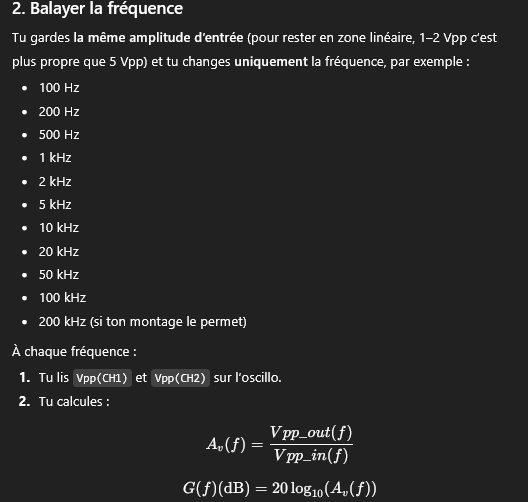

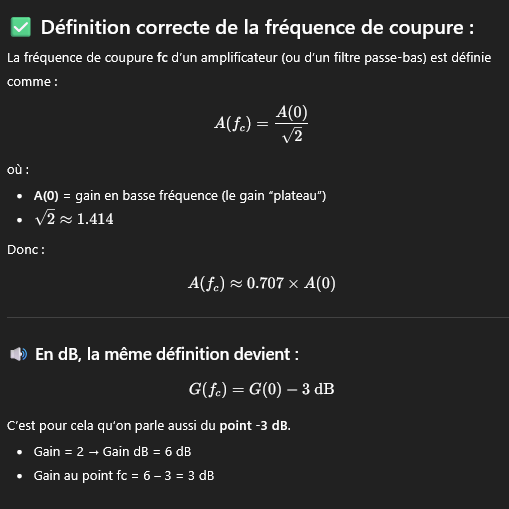 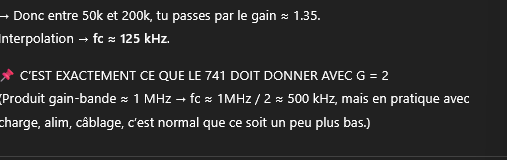

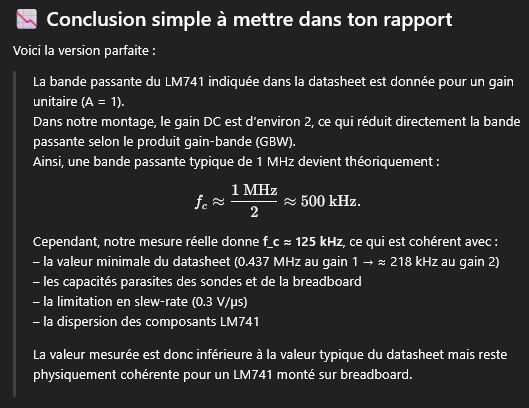

# Slew rate

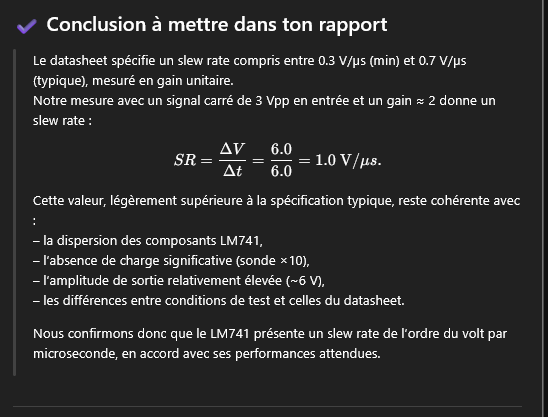

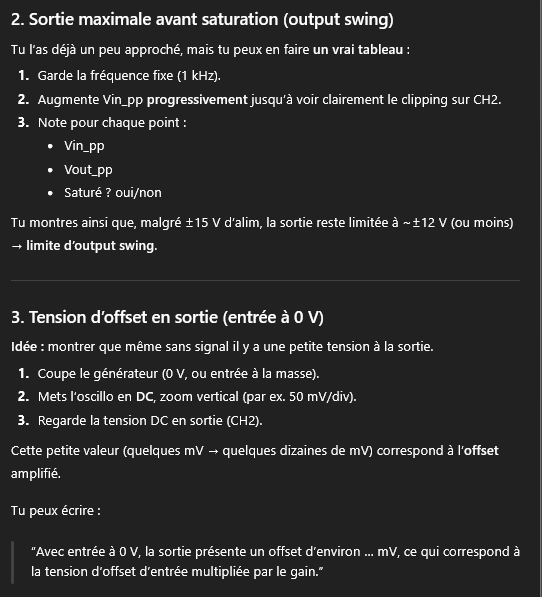